# Grasp Detection on the Cornell Dataset

This notebook provides a demonstration on training and inferencing a grasp detection model on the __[Cornell](https://www.kaggle.com/datasets/oneoneliu/cornell-grasp)__ dataset. Other suitable datasets can be used by changing the root dataset directory path `root_dir` and the dataset annotation file path `annotation_path` in the dataset object `GraspDetectionDataset`. If training a model or visualizing a dataset, you will need to generate a JSON annotation file for the dataset you want to use (refer to the __[README](../README.md/#generating-annotation-files)__ for additional details). An annotation file is not needed for inferencing the model with random images.



In [1]:
# import standard libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as T
torch.manual_seed(10)

# add root code directory to python path
current_dir = os.path.dirname(os.path.abspath(''))
print(f"[INFO] Adding '{current_dir}' to python path.")
sys.path.append(current_dir)

# import libraries from os_tog
import os_tog.model as m
import os_tog.dataset as d
from os_tog.config import GraspDetectionConfig as cfg
from os_tog.utils import visualize, print_losses

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

[INFO] Adding 'd:\PhD Projects\OS_TOG (Github)' to python path.


## Loading a Dataset

The code below is used to generate dataset objects and data loaders, as well as preview some grasp annotations from the dataset.

In [2]:
# define transformations
def get_transform(train=True):
    transforms = []
    if train:
        transforms.append(d.RandomShift(px=25, shift="x"))
        transforms.append(d.RandomHorizontalFlip(p=0.5))
    transforms.append(d.CustomCrop(80, 140, 400))    
    transforms.append(d.ToTensor())
    return d.Compose(transforms)

# create dataset objects
train_dataset = d.GraspDetectionDataset(
    data_dir=cfg.CORNELL_PATH, 
    annotation_file=os.path.join(cfg.CORNELL_ANNOT_PATH, "Cornell_training_annotations.json"), 
    transforms=get_transform(), 
    rot_classes=cfg.ROTATION_CLASSES
)
test_dataset = d.GraspDetectionDataset(
    data_dir=cfg.CORNELL_PATH, 
    annotation_file=os.path.join(cfg.CORNELL_ANNOT_PATH, "Cornell_testing_annotations.json"), 
    transforms=get_transform(train=False), 
    rot_classes=cfg.ROTATION_CLASSES
)

# create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=cfg.TRAIN_BATCH_SIZE, shuffle=True, num_workers=cfg.NUM_WORKERS, collate_fn=d.collate_fn
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=cfg.VAL_BATCH_SIZE, shuffle=False, num_workers=cfg.NUM_WORKERS, collate_fn=d.collate_fn
)

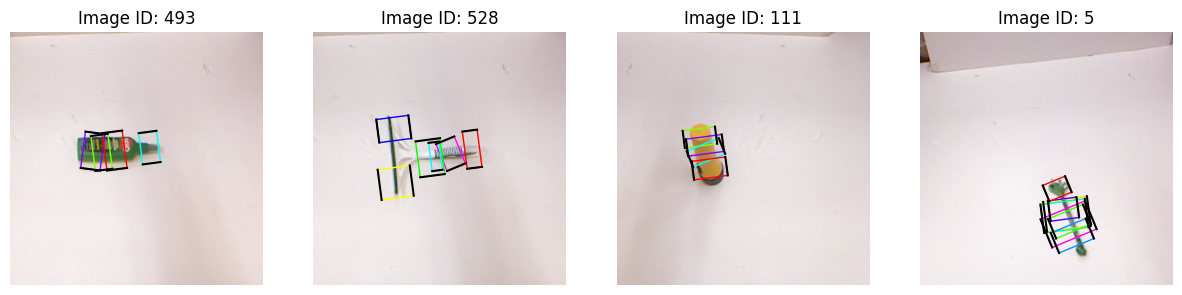

In [3]:
batch = next(iter(train_loader)) # get batch
_, ax = plt.subplots(cfg.TRAIN_BATCH_SIZE//4, 4, figsize=(15, 6))

for batch_idx in range(len(batch[0])):
    img, target = batch[0][batch_idx], batch[1][batch_idx]
    img = np.array(torchvision.transforms.ToPILImage()(img)) # convert image from tensor to image for plotting
    grasps = np.array([train_dataset.VOC_to_5D_grasp_pose(target['boxes'][i], target['labels'][i].item()) for i in range(len(target['boxes']))], dtype=np.float32)
    visualize(img, grasps=grasps, ax=ax[batch_idx], title=f"Image ID: {target['image_id'].item()}")

## Building a Model

The code below builds a Faster R-CNN grasp detection model and displays its structure and parameters.

In [4]:
num_classes = len(train_dataset.class_info.keys())
model = m.build_grasp_detection_model(num_classes, cfg.ANCHOR_SIZES, cfg.ASPECT_RATIOS)

In [5]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print("[INFO] Total model params:", pytorch_total_params)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("[INFO] Total trainable params:", pytorch_total_params)

print("[INFO] Printing model...")
print(model)

[INFO] Total model params: 41355536
[INFO] Total trainable params: 41133136
[INFO] Printing model...
FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=

## Training a Model

The code below can be used to train the model for N epochs. It prints losses and saves the model at each epoch.

In [6]:
# set model to GPU for training
model.to(DEVICE)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=cfg.LEARNING_RATE)

train_hist = {}  # to store training and validation losses
for epoch in range(1, cfg.EPOCHS+1):
    # train model for one epoch
    train_hist = m.train_grasp_detection_model(model, train_loader, optimizer, epoch, DEVICE, train_hist)
    print_losses(train_hist, epoch)
    m.save_model(model, cfg.MODEL_DIR, f"{cfg.MODEL_NAME}_{epoch}.pt")

Training Epoch 1: 100%|██████████| 199/199 [01:04<00:00,  3.09it/s, loss=1.42] 


Epoch 1 - loss: 1.1546 - cls_loss: 0.5953 - bbox_loss: 0.4651 - rpn_cls_loss: 0.0672 - rpn_bbox_loss: 0.0272
[INFO] Saving checkpoint '../models/grasp_detection\fasterrcnn_cornell_t1_1.pt'


Training Epoch 2: 100%|██████████| 199/199 [01:01<00:00,  3.21it/s, loss=1.3]  


Epoch 2 - loss: 1.0467 - cls_loss: 0.4764 - bbox_loss: 0.5172 - rpn_cls_loss: 0.0293 - rpn_bbox_loss: 0.0238
[INFO] Saving checkpoint '../models/grasp_detection\fasterrcnn_cornell_t1_2.pt'


Training Epoch 3: 100%|██████████| 199/199 [01:01<00:00,  3.25it/s, loss=1.02] 


Epoch 3 - loss: 1.0316 - cls_loss: 0.4567 - bbox_loss: 0.5270 - rpn_cls_loss: 0.0250 - rpn_bbox_loss: 0.0229
[INFO] Saving checkpoint '../models/grasp_detection\fasterrcnn_cornell_t1_3.pt'


Training Epoch 4: 100%|██████████| 199/199 [01:00<00:00,  3.27it/s, loss=0.968]


Epoch 4 - loss: 1.0036 - cls_loss: 0.4409 - bbox_loss: 0.5199 - rpn_cls_loss: 0.0212 - rpn_bbox_loss: 0.0216
[INFO] Saving checkpoint '../models/grasp_detection\fasterrcnn_cornell_t1_4.pt'


Training Epoch 5: 100%|██████████| 199/199 [01:00<00:00,  3.29it/s, loss=0.828]


Epoch 5 - loss: 0.9650 - cls_loss: 0.4155 - bbox_loss: 0.5088 - rpn_cls_loss: 0.0196 - rpn_bbox_loss: 0.0211
[INFO] Saving checkpoint '../models/grasp_detection\fasterrcnn_cornell_t1_5.pt'


## Inferencing a Model

The code below is used to load a checkpoint and inference the model on either samples from the test dataset or on a random image.

In [10]:
num_classes = cfg.ROTATION_CLASSES + 1
model = m.build_grasp_detection_model(num_classes, cfg.ANCHOR_SIZES, cfg.ASPECT_RATIOS)
model = m.load_model(model, "../models/grasp_detection/fasterrcnn_cornell_t1_5.pt")
model.eval()
model.to(DEVICE);

[INFO] Loading checkpoint '../models/grasp_detection/fasterrcnn_cornell_t1_5.pt'
[INFO] Loaded checkpoint '../models/grasp_detection/fasterrcnn_cornell_t1_5.pt'


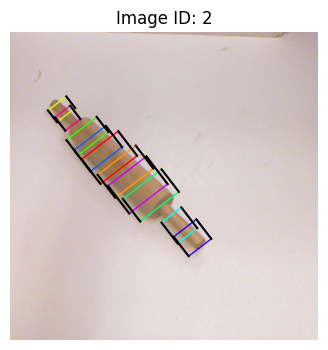

In [18]:
img, target = test_dataset.__getitem__(1) 
img = img.to(DEVICE)
pred_boxes, pred_class = m.inference_grasp_detection_model(model, img, confidence=0.2)
img = np.array(torchvision.transforms.ToPILImage()(img)) # convert image from tensor to image for plotting
grasps = np.array([train_dataset.VOC_to_5D_grasp_pose(target['boxes'][i], target['labels'][i].item()) for i in range(len(target['boxes']))], dtype=np.float32)
visualize(img, grasps=grasps, title=f"Image ID: {target['image_id'].item()}")

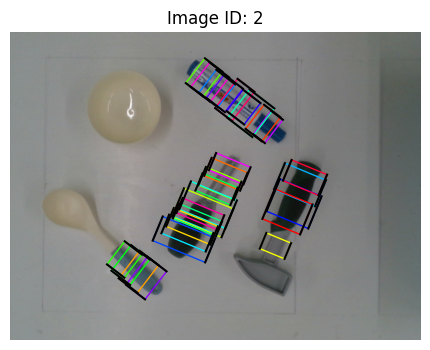

In [19]:
img_path = "../samples/example_scene.png"
img = Image.open(img_path)
transform = T.Compose([T.ToTensor()])
img = transform(img)
img = img.to(DEVICE)
pred_boxes, pred_class = m.inference_grasp_detection_model(model, img, confidence=0.5)
img = np.array(torchvision.transforms.ToPILImage()(img)) # convert image from tensor to image for plotting
grasps = np.array([train_dataset.VOC_to_5D_grasp_pose(pred_boxes[i], pred_class[i].item()) for i in range(len(pred_boxes))], dtype=np.float32)
visualize(img, grasps=grasps, title=f"Image ID: {target['image_id'].item()}")
